<a href="https://colab.research.google.com/github/Tony607/detectron2_instance_segmentation_demo/blob/master/Detectron2_custom_coco_data_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [How to train Detectron2 with Custom COCO Datasets](https://www.dlology.com/blog/how-to-train-detectron2-with-custom-coco-datasets/) | DLology

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

This notebook will help you get started with this framwork by training a instance segmentation model with your custom COCO datasets.

# Install detectron2

In [1]:
!pip install -U torch torchvision
!pip install git+https://github.com/facebookresearch/fvcore.git
import torch, torchvision
torch.__version__

     |████████████████████████████████| 773.1MB 29kB/s 
     |████████████████████████████████| 10.1MB 39.6MB/s 
  Found existing installation: torch 1.2.0
    Uninstalling torch-1.2.0:
      Successfully uninstalled torch-1.2.0
  Found existing installation: torchvision 0.4.0
    Uninstalling torchvision-0.4.0:
      Successfully uninstalled torchvision-0.4.0
  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-req-build-2ch8hj3k
  Running command git clone -q https://github.com/facebookresearch/fvcore.git /tmp/pip-req-build-2ch8hj3k
     |████████████████████████████████| 266kB 9.1MB/s 
  Created wheel for fvcore: filename=fvcore-0.1-cp36-none-any.whl size=46446 sha256=aa4f9d513575d2abb6697655f22ea0d1e63070c353a3ea14eddacdcfc15eb9b5
  Stored in directory: /tmp/pip-ephem-wheel-cache-wl2e8_uq/wheels/48/53/79/3c6485543a4455a0006f5db590ab9957622b6227011941de06
  Created wheel for pyyaml: filename=PyYAML-5.1.2-cp36-cp36m-linux_x86_64.whl size=44104 sha256=5c1cde9a506593db5

'1.3.0'

In [2]:
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

Cloning into 'detectron2_repo'...
remote: Enumerating objects: 588, done.
remote: Counting objects: 100% (588/588), done.
remote: Compressing objects: 100% (373/373), done.
remote: Total 588 (delta 220), reused 570 (delta 212), pack-reused 0
Receiving objects: 100% (588/588), 1.43 MiB | 3.09 MiB/s, done.
Resolving deltas: 100% (220/220), done.
Obtaining file:///content/detectron2_repo
     |████████████████████████████████| 61kB 5.0MB/s 
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1
  Running setup.py develop for detectron2


In [0]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Train on a custom COCO dataset

In this section, we show how to train an existing detectron2 model on a custom dataset in a new format.

We use [the fruits nuts segmentation dataset](https://github.com/Tony607/mmdetection_instance_segmentation_demo)
which only has 3 classes: data, fig, and hazelnut.
We'll train a segmentation model from an existing model pre-trained on the COCO dataset, available in detectron2's model zoo.

Note that the COCO dataset does not have the "data", "fig" and "hazelnut" categories.

In [0]:
# download, decompress the data
!wget https://github.com/Tony607/detectron2_instance_segmentation_demo/releases/download/V0.1/data.zip
!unzip data.zip > /dev/null

Register the fruits_nuts dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).


In [0]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("fruits_nuts", {}, "./data/trainval.json", "./data/images")

In [4]:
fruits_nuts_metadata = MetadataCatalog.get("fruits_nuts")
dataset_dicts = DatasetCatalog.get("fruits_nuts")

[10/13 09:52:18 d2.data.datasets.coco]: Loaded 18 images in COCO format from ./data/trainval.json


To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



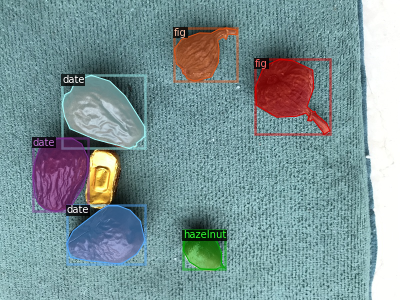

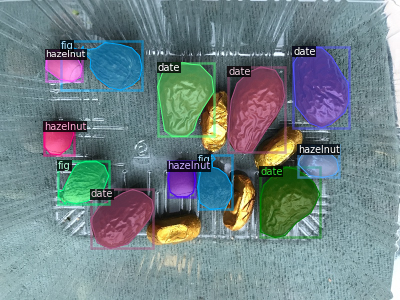

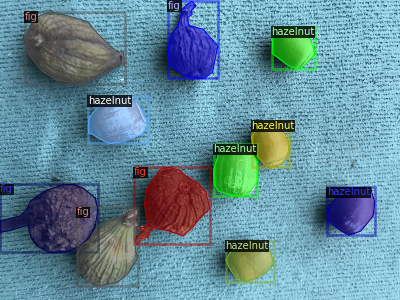

In [5]:
import random

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=fruits_nuts_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

Now, let's fine-tune a coco-pretrained R50-FPN Mask R-CNN model on the fruits_nuts dataset. It takes ~6 minutes to train 300 iterations on Colab's K80 GPU.


In [6]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file("./detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("fruits_nuts",)
cfg.DATASETS.TEST = ()   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.02
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # 3 classes (data, fig, hazelnut)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

WARNING [10/13 09:52:31 d2.config.compat]: Config './detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.
[10/13 09:52:34 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
    

'roi_heads.box_predictor.cls_score.weight' has shape (81, 1024) in the checkpoint but (4, 1024) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (4,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 1024) in the checkpoint but (12, 1024) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (12,) in the model! Skipped.
'roi_heads.mask_head.predictor.weight' has shape (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) in the model! Skipped.
'roi_heads.mask_head.predictor.bias' has shape (80,) in the checkpoint but (3,) in the model! Skipped.


[10/13 09:52:37 d2.engine.train_loop]: Starting training from iteration 0
[10/13 09:53:02 d2.utils.events]: eta: 0:05:55  iter: 19  total_loss: 2.575  loss_cls: 1.036  loss_box_reg: 0.882  loss_mask: 0.627  loss_rpn_cls: 0.020  loss_rpn_loc: 0.019  time: 1.2948  data_time: 0.0036  lr: 0.000400  max_mem: 2336M
[10/13 09:53:28 d2.utils.events]: eta: 0:05:33  iter: 39  total_loss: 1.572  loss_cls: 0.473  loss_box_reg: 0.833  loss_mask: 0.247  loss_rpn_cls: 0.006  loss_rpn_loc: 0.018  time: 1.2961  data_time: 0.0035  lr: 0.000799  max_mem: 2336M
[10/13 09:53:54 d2.utils.events]: eta: 0:05:08  iter: 59  total_loss: 0.749  loss_cls: 0.195  loss_box_reg: 0.458  loss_mask: 0.089  loss_rpn_cls: 0.001  loss_rpn_loc: 0.023  time: 1.2929  data_time: 0.0037  lr: 0.001199  max_mem: 2336M
[10/13 09:54:21 d2.utils.events]: eta: 0:04:49  iter: 79  total_loss: 0.433  loss_cls: 0.100  loss_box_reg: 0.242  loss_mask: 0.074  loss_rpn_cls: 0.001  loss_rpn_loc: 0.022  time: 1.3056  data_time: 0.0036  lr: 0.0

OrderedDict()

Now, we perform inference with the trained model on the fruits_nuts dataset. First, let's create a predictor using the model we just trained:



In [0]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("fruits_nuts", )
predictor = DefaultPredictor(cfg)

Then, we randomly select several samples to visualize the prediction results.

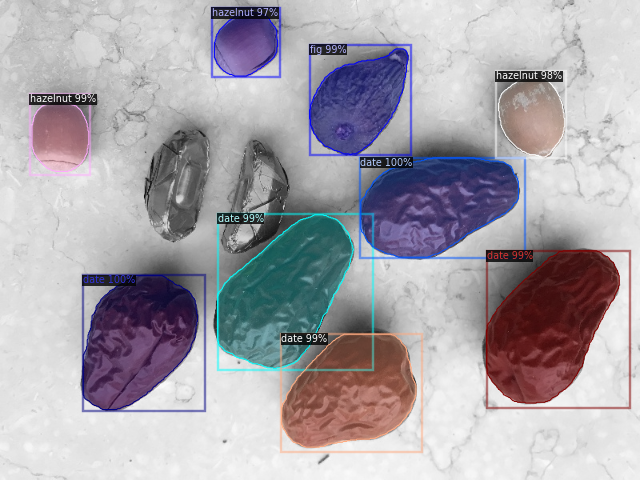

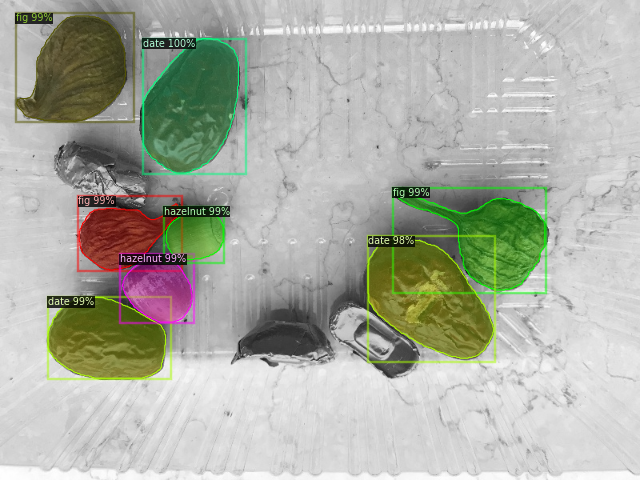

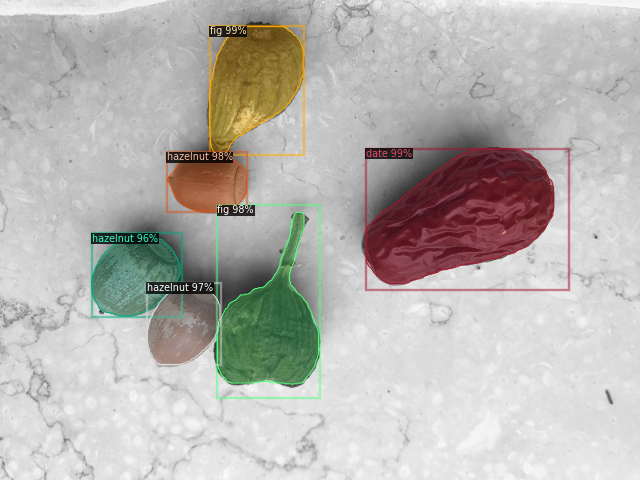

In [8]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=fruits_nuts_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

In [11]:
fruits_nuts_metadata

Metadata(evaluator_type='coco', image_root='./data/images', json_file='./data/trainval.json', name='fruits_nuts', thing_classes=['date', 'fig', 'hazelnut'], thing_dataset_id_to_contiguous_id={1: 0, 2: 1, 3: 2})

## Benchmark inference speed

In [14]:
import time
times = []
for i in range(20):
    start_time = time.time()
    outputs = predictor(im)
    delta = time.time() - start_time
    times.append(delta)
mean_delta = np.array(times).mean()
fps = 1 / mean_delta
print("Average(sec):{:.2f},fps:{:.2f}".format(mean_delta, fps))

Average(sec):0.39,fps:2.59
